<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/notebooks/covidradio_weighted_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data.zip

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py


Mounted at /content/drive
--2021-08-29 07:06:15--  https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5134 (5.0K) [text/plain]
Saving to: ‘util.py’

util.py             100%[===================>]   5.01K  --.-KB/s    in 0s      

2021-08-29 07:06:15 (40.7 MB/s) - ‘util.py’ saved [5134/5134]



In [2]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

import util

#### Get metadata on training set 

In [3]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

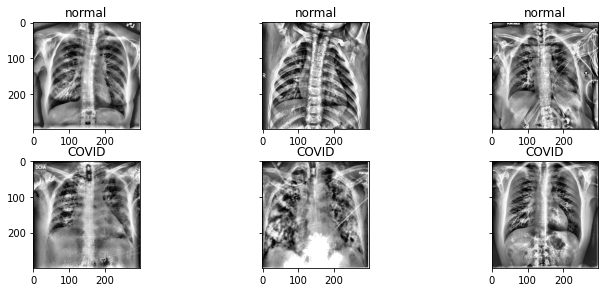

In [4]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

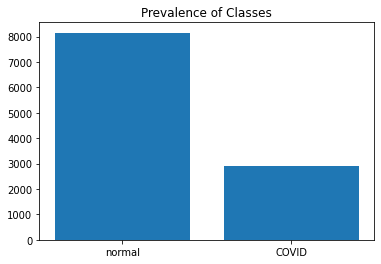

In [5]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Data generators to import images into the classifier

In [4]:
datagen = ImageDataGenerator(rescale=1./255.)

train_path = os.path.join(data_path, 'train')
train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

valid_path = os.path.join(data_path, 'valid')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=False,
                    class_mode='binary',
                    classes=classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


#### Build a simple CNN as a baseline

In [7]:
model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
                    MaxPooling2D(2, 2),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(256, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                   
                    Flatten(),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       7

#### Compile and train

In [9]:
model.compile(loss=util.Weighted_Loss(train_gen.classes), optimizer='adam', metrics=['accuracy'])

stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit(train_gen,
                    epochs=25,
                    steps_per_epoch=len(train_gen),
                    validation_data=valid_gen,
                    validation_steps=len(valid_gen),
                    verbose=1,
                    callbacks=[stop, reduce_lr])

Epoch 1/25
346/346 [==============================] - 81s 146ms/step - loss: 0.2057 - accuracy: 0.7675 - val_loss: 0.1396 - val_accuracy: 0.8087
Epoch 2/25
346/346 [==============================] - 50s 144ms/step - loss: 0.1070 - accuracy: 0.8880 - val_loss: 0.0996 - val_accuracy: 0.9029
Epoch 3/25
346/346 [==============================] - 49s 141ms/step - loss: 0.0689 - accuracy: 0.9293 - val_loss: 0.0966 - val_accuracy: 0.9254
Epoch 4/25
346/346 [==============================] - 49s 142ms/step - loss: 0.0497 - accuracy: 0.9470 - val_loss: 0.0727 - val_accuracy: 0.9471
Epoch 5/25
346/346 [==============================] - 49s 141ms/step - loss: 0.0364 - accuracy: 0.9644 - val_loss: 0.0578 - val_accuracy: 0.9399
Epoch 6/25
346/346 [==============================] - 49s 141ms/step - loss: 0.0286 - accuracy: 0.9716 - val_loss: 0.0766 - val_accuracy: 0.9413
Epoch 7/25
346/346 [==============================] - 49s 141ms/step - loss: 0.0237 - accuracy: 0.9759 - val_loss: 0.0630 - val_ac

In [10]:
model_path = os.path.join(BASE_PATH, 'weighted_model.h5')
model.save(model_path)

#### Evaluate the model

(Accuracy is not everything.)

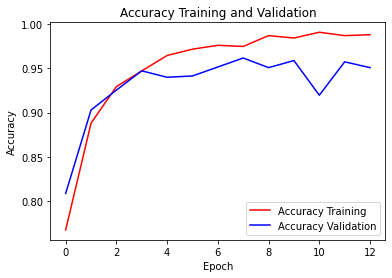

In [11]:
plt.plot(history.history['accuracy'], 'r', label='Accuracy Training')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [5]:
model_path = os.path.join(BASE_PATH, 'weighted_model.h5')
model = load_model(model_path, compile=False)
model.compile(loss=util.Weighted_Loss(train_gen.classes), optimizer='adam', 
              metrics=['accuracy'])

In [12]:
score = model.evaluate(valid_gen, steps=len(valid_gen))
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 5s 103ms/step - loss: 0.0563 - accuracy: 0.9616
Accuracy Score = 96.0%


#### Calculate confusion matrix, precision, recall, f1

44/44 [==============================] - 32s 100ms/step


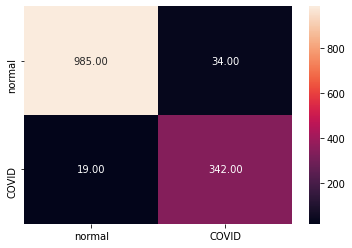

In [6]:
y_true = np.array(valid_gen.classes)
y_true = np.expand_dims(y_true, axis=1)
y_pred = model.predict(valid_gen, verbose=1)
y_pred = y_pred > 0.5
y_pred = y_pred.astype(np.uint8)
cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

#### ROC-AUC curve and AUC score

#### Calculate Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [7]:
labels = ['covid']
metrics_df, roc_curves = util.model_metrics(y_true, y_pred, labels)
metrics_df

,Accuracy,Sensitivity,Specificity,PPV,Auc_score
covid,0.961594,0.947368,0.966634,0.909574,0.957001


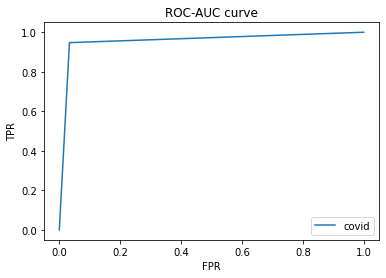

In [8]:
for i, curve in enumerate(roc_curves):
  plt.plot(curve[0], curve[1], label=labels[i])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curve')
plt.legend()
plt.show()

#### Individual prediction from the test set

We'll just pick a random example and run it through the model

In [9]:
counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'test', item))
    filelists.append(filelist)
    counts.append(len(filelist))

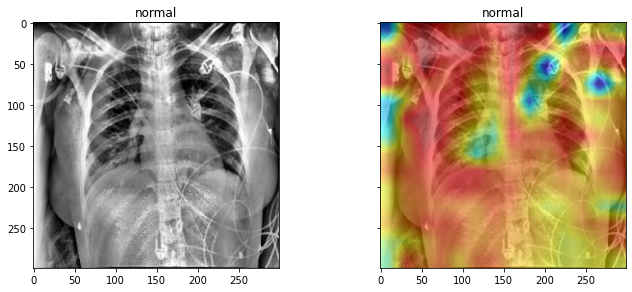

Actual class: normal
Predicted class: normal
Confidence: 58.97%


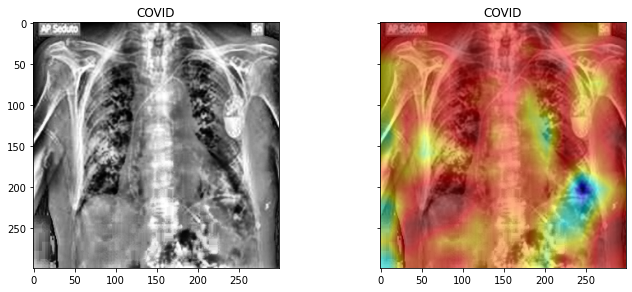

Actual class: COVID
Predicted class: COVID
Confidence: 97.76%


In [34]:
for i, item in enumerate(classes):

    f, axes = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(10)
    plt.tight_layout()

    image_file = random.choice(filelists[i])
    image_path = os.path.join(data_path, 'test', item, image_file)
    image = load_img(image_path)
    image = img_to_array(image)

    pred_image = np.expand_dims(image, axis=0)
    pred_image = pred_image / 255.
    pred = model.predict(pred_image)
    prediction = int(pred[0][0] >= 0.5)

    if prediction:
      confidence = round(pred[0][0] * 100, 2)
    else:
      confidence = round((1 - pred[0][0]) * 100, 2)

    img = plt.imread(image_path)
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title(item)

    cam = util.grad_cam(model, pred_image, 0, 'conv2d_4')

    img = plt.imread(image_path)
    axes[1].imshow(img, cmap='gray')
    axes[1].imshow(cam, cmap='jet', alpha=0.5)
    axes[1].set_title(item)
    plt.show()

    print(f'Actual class: {item}')
    print(f'Predicted class: {classes[prediction]}')
    print(f'Confidence: {confidence}%')



